# Simple OCR example

In [ ]:
# from google.colab import drive

# # Mount the Google Drive at /content/drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/dataset_ocr.zip

# Create train/val splits from original dataset

In [3]:
# Original dataset from: https://www.kaggle.com/datasets/nickyazdani/license-plate-text-recognition-dataset

from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import keras_cv

# Create these and move downloaded dataset files to DATASET_ORIGINAL_PATH
DATASET_ORIGINAL_PATH = 'dataset_original'
OCR_DATASET_PATH = 'dataset_ocr'


def create_ocr_dataset(csv_path):
    df = pd.read_csv(csv_path)[['images', 'labels']]
    ds_dict = df.to_dict()

    # Split the dataset into train, validation, and test sets
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

    # Create directories for train, val, and test images
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(OCR_DATASET_PATH, split, 'img'), exist_ok=True)
        os.makedirs(os.path.join(OCR_DATASET_PATH, split, 'annot'), exist_ok=True)

    # Copy images and create annotation files for train, val, and test sets
    for split, df_split in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
        for _, row in df_split.iterrows():
            img_src = os.path.join(DATASET_ORIGINAL_PATH, 'images', row['images'])
            img_dst = os.path.join(OCR_DATASET_PATH, split, 'img', row['images'])
            shutil.copy(img_src, img_dst)

            # Write annotation string to a text file
            annot_dst = os.path.join(OCR_DATASET_PATH, split, 'annot', os.path.splitext(row['images'])[0] + '.txt')
            with open(annot_dst, 'w') as f:
                f.write(row['labels'])

create_ocr_dataset(os.path.join(DATASET_ORIGINAL_PATH, "lpr.csv"))

# Create Tensorflow Datasets for training

In [4]:
# Define your constants
OCR_DATASET_PATH = 'dataset_ocr'
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
MAX_SEQ_LENGTH = 6
BATCH_SIZE = 64

ocr_characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(ocr_characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Augmentations module
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomRotation(factor=0.10, fill_mode="constant"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=None
        ),
        keras_cv.layers.Solarization(value_range=(0, 255)),
        keras_cv.layers.RandomGaussianBlur(kernel_size=(3,3), factor=(0.5, 1.5))

    ]
)

# Load/pre-process image and encode ground truth function for a single sample
def encode_single_sample(img_path, label, augment = False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

    # Convert to gray scale
    img = tf.image.rgb_to_grayscale(img)

    if augment:
        img = augmenter(img)

    # Convert to float32 and normalize to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Transpose so the width of the image batch the time dimension
    img = tf.transpose(img, perm=[1, 0, 2])

    # Map the characters in label to numbers
    label_string = tf.io.read_file(label)
    label = char_to_num(tf.strings.unicode_split(label_string, input_encoding="UTF-8"))

    return {"image": img, "label": label}

def create_tf_dataset(data_dir, augment= False):
    img_files = sorted(os.listdir(os.path.join(data_dir, 'img')))
    annot_files = sorted(os.listdir(os.path.join(data_dir, 'annot')))
    img_paths = [os.path.join(data_dir, 'img', filename) for filename in img_files]
    annot_paths = [os.path.join(data_dir, 'annot', filename) for filename in annot_files]

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, annot_paths))
    dataset = dataset.map(lambda img_path, annot_path: encode_single_sample(img_path, annot_path, augment), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size = BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(os.path.join(OCR_DATASET_PATH, "train"), augment=True).shuffle(buffer_size=512)
val_dataset = create_tf_dataset(os.path.join(OCR_DATASET_PATH, "val")).shuffle(buffer_size = 512)
test_dataset = create_tf_dataset(os.path.join(OCR_DATASET_PATH, "test")).shuffle(buffer_size = 512)

# Visualize some samples

2024-05-22 21:55:28.396528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 55 of 512
2024-05-22 21:55:38.391977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 103 of 512
2024-05-22 21:55:48.385845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 157 of 512
2024-05-22 21:55:53.738195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


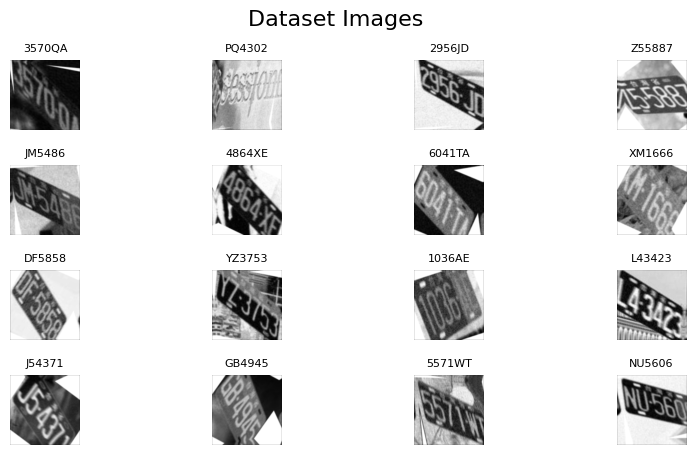

In [6]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label, fontsize=8)
        ax[i // 4, i % 4].axis("off")

    plt.suptitle("Dataset Images", fontsize=16)
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# CTC Layer and parts from: https://keras.io/examples/vision/captcha_ocr/#inference

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), dtype=tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), dtype=tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), dtype=tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + tf.keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), dtype=tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, dtype=tf.int64),
        vals_sparse,
        tf.cast(label_shape, dtype=tf.int64)
    )

class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int64)
        input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int64)
        label_length = tf.cast(tf.shape(y_true)[1], dtype=tf.int64)

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype=tf.int64)

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


In [ ]:
def build_model(img_width, img_height, char_to_num):
    inputs = tf.keras.Input(shape=(img_width, img_height, 1), name="image", dtype=tf.float32)
    labels = tf.keras.Input(name="label", shape=(None,), dtype=tf.float32)

    # CNN Blocks
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1"
    )(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = tf.keras.layers.Conv2D(
        64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2"
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshape before passing to RNN
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # RNNs
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer for inference model
    x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer (only for training model)
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs=[inputs, labels], outputs=output, name="simple_ocr")
    model.compile(optimizer=tf.keras.optimizers.Adam())

    return model

model = build_model(IMAGE_WIDTH, IMAGE_HEIGHT, char_to_num)
model.summary()

In [ ]:
epochs = 100
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Create inference model and test inference

In [ ]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + tf.keras.backend.epsilon())
    input_length = tf.cast(input_length, dtype=tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)

prediction_model = tf.keras.Model(
    inputs=model.input[0],
    outputs=model.get_layer(name="dense2").output,
    name="ocr_inference"
)
prediction_model.summary()


def decode_batch_predictions(pred, max_length, num_to_char):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Assuming val_dataset, num_to_char, and max_length are defined
for batch in val_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, MAX_SEQ_LENGTH, num_to_char)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    num_predictions = len(pred_texts)
    num_rows = min(4, num_predictions)
    num_cols = min(4, num_predictions)

    _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title, fontsize = 8)
        ax[i // 4, i % 4].axis("off")

    plt.suptitle("Predictions", fontsize=16)
    plt.subplots_adjust(hspace=0.5)

plt.show()

# Evaluate

In [ ]:
all_pred_chars = []
all_true_chars = []

test_iterator = iter(test_dataset)
while True:
    try:
        batch = next(test_iterator)
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict labels using the trained model
        preds = prediction_model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds, MAX_SEQ_LENGTH, num_to_char)

        # Convert ground truth labels to human-readable text
        true_texts = []
        for label in batch_labels:
            true_texts.append(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))

        # Flatten the predicted and true texts to get individual characters
        pred_chars = [char for text in pred_texts for char in text]
        true_chars = [char for text in true_texts for char in text]

        # Ensure consistent sequence lengths
        max_len = MAX_SEQ_LENGTH
        pred_chars = pred_chars[:max_len] + [-1] * (max_len - len(pred_chars))
        true_chars = true_chars[:max_len]

        # Accumulate predictions and ground truth labels for individual characters
        all_pred_chars.extend(pred_chars)
        all_true_chars.extend(true_chars)

    except StopIteration:
        break

# Calculate character accuracy
char_accuracy = accuracy_score(all_true_chars, all_pred_chars)

# Calculate precision, recall, and F1-score for each class (character)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_chars, all_pred_chars, average=None)

# Calculate average precision, recall, and F1-score
avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(all_true_chars, all_pred_chars, average='weighted')

# Print performance metrics
print("Character Accuracy:", char_accuracy)
print(f"\nAverage Precision: {avg_precision} | Average Recall: {avg_recall} | Average F1: {avg_f1}")
print("\nClassification Report:")
print(classification_report(all_true_chars, all_pred_chars, zero_division= 0))

# Save model

In [ ]:
import os

# Function to save the trained model
def save_model(model_to_save, model_dir):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_to_save.save(model_dir)

# Save the model
save_model(prediction_model, 'ocr_artifacts/ocr_model/')